In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from urllib.parse import urlparse
from S01_dataset_preprocessing_pipeline import all_dataset
import torch.nn.functional as F
import torch.optim as optim
import random
import math
from trainer_class import Trainer
tqdm.pandas()
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"✅ Seed fixed to {seed}")

✅ Seed fixed to 42


In [ ]:
# ============================================================
# Character Encoding Setup
# ============================================================

# Allowed printable ASCII chars
ascii_chars = [chr(i) for i in range(32, 127)]

# Special control tokens
special_tokens = [
    '<PAD>', '<UNK>',
]

# Build vocab and mapping
vocab = special_tokens + ascii_chars
char2idx = {ch: i for i, ch in enumerate(vocab)}



def encode(text, max_len=60):
    indices = torch.full((max_len,), char2idx["<PAD>"], dtype=torch.long)
    text = text.lower()[:max_len]
    for i, c in enumerate(text):
        indices[i] = char2idx.get(c, char2idx["<UNK>"])

    return indices





encoded_data = {}
frac = 1
gen = all_dataset()

x=0

max_len=128
#next(gen)
#next(gen)
#next(gen)
for name, splits in  gen:
    encoded_data[name] = {}
    print(f"\nEncoding structured URLs for {name}...")

    for split_name, df in zip(['train', 'valid', 'test'], splits):
        df = df.sample(frac=frac, random_state=42)
        df["encode"] = df["url"].progress_apply(lambda url: encode(url, max_len=max_len))
        encoded_data[name][split_name] = df
        print(f"{split_name}: Encoded {len(df)} URLs")


    #if x == 1:
    #    next(gen)
    x+=1


print("\nAll datasets encoded with proper start/end markers and padding!")


Encoding structured URLs for Dataset 1 (Malicious URLs)...


100%|██████████| 417732/417732 [01:19<00:00, 5271.73it/s]


train: Encoded 417732 URLs


100%|██████████| 52217/52217 [00:09<00:00, 5344.47it/s]


valid: Encoded 52217 URLs


100%|██████████| 52217/52217 [00:10<00:00, 5013.80it/s]


test: Encoded 52217 URLs

Encoding structured URLs for Dataset 2 (ndarvind/phiusiil-phishing)...


100%|██████████| 188296/188296 [00:23<00:00, 7990.18it/s]


train: Encoded 188296 URLs


100%|██████████| 23537/23537 [00:03<00:00, 7802.79it/s]


valid: Encoded 23537 URLs


100%|██████████| 23537/23537 [00:03<00:00, 7567.94it/s]


test: Encoded 23537 URLs

Encoding structured URLs for Dataset 3 (kmack/Phishing_urls)...


100%|██████████| 528097/528097 [01:28<00:00, 5951.52it/s]


train: Encoded 528097 URLs


100%|██████████| 66013/66013 [00:10<00:00, 6002.44it/s]


valid: Encoded 66013 URLs


100%|██████████| 66012/66012 [00:10<00:00, 6286.65it/s]


test: Encoded 66012 URLs

Encoding structured URLs for Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)...


 40%|████      | 163905/405756 [00:29<00:49, 4903.75it/s]

In [ ]:
# ============================================================
# Convert to TensorDataset and DataLoader
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024

dataloader_dict = {}

def make_tensor_dataset(df):
    url_tensor = torch.stack(list(df["encode"]))
    labels_tensor = torch.tensor(df["label"].astype(np.float32).values, dtype=torch.long)
    return TensorDataset(url_tensor, labels_tensor)

for name, splits in encoded_data.items():
    dataloader_dict[name] = {}
    print(f"\n📦 Creating DataLoaders for {name}...")
    
    train_set = make_tensor_dataset(splits["train"])
    val_set = make_tensor_dataset(splits["valid"])
    test_set = make_tensor_dataset(splits["test"])
    
    dataloader_dict[name]["train_loader"] = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    dataloader_dict[name]["val_loader"] = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    dataloader_dict[name]["test_loader"] = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"DataLoaders ready for {name} (Train/Val/Test)")

print("\nAll DataLoaders are ready in `dataloader_dict`!")

# Example Access:
# dataloader_dict["dataset1"]["train_loader"]



📦 Creating DataLoaders for Dataset 1 (Malicious URLs)...
DataLoaders ready for Dataset 1 (Malicious URLs) (Train/Val/Test)

📦 Creating DataLoaders for Dataset 2 (ndarvind/phiusiil-phishing)...
DataLoaders ready for Dataset 2 (ndarvind/phiusiil-phishing) (Train/Val/Test)

📦 Creating DataLoaders for Dataset 3 (kmack/Phishing_urls)...
DataLoaders ready for Dataset 3 (kmack/Phishing_urls) (Train/Val/Test)

📦 Creating DataLoaders for Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)...
DataLoaders ready for Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls) (Train/Val/Test)

All DataLoaders are ready in `dataloader_dict`!


In [ ]:
# =====================================================
# 🔹  Embeding_layer
# =====================================================
class Embeding_layer(nn.Module):
    def __init__(self,
                 vocab_size=256,
                 d_model=128,
                 max_len=100,
                 n_out=128,):
        super().__init__()

        # Byte embedding layer (0–255)
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Positional embeddings
        #self.pos_embedding = nn.Embedding(max_len, d_model)
        # Final normalization
        
        self.projection = nn.Linear(in_features=d_model, out_features=n_out)
        self.norm = nn.LayerNorm(n_out)
        self.activation = nn.GELU()

    def forward(self, x):
        """
        x: (batch, seq_len) — byte indices [0–255]
        """
        #positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        x = self.embedding(x) #+ self.pos_embedding(positions)

        x = self.projection(x)
        x = self.norm(x)
        x = self.activation(x)

        return x  # (B, L, d_model)

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, L)
        w = x.mean(dim=2)                          # Global Average Pooling -> (B, C)
        w = F.elu(self.fc1(w))
        w = self.sigmoid(self.fc2(w))
        w = w.unsqueeze(2)                         # (B, C, 1)
        return x * w                               # scale features

In [ ]:
# 🔹 Residual Depthwise-Separable Multi-Kernel Block
class ResidualConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_sizes=[3],stride=1, dilations=[1], reduction=16, num_groups=32):
        super().__init__()

        #mid_ch = max(in_ch // 16, 8)  # reduce dimension before heavy convs
        self.branches = nn.ModuleList()

        for k in kernel_sizes:
            if k <= 5:
                for d in dilations:
                    branch = nn.Sequential(
                        # (B) Reduce channels first
                        #nn.Conv1d(in_ch, 1, kernel_size=1, bias=False),
                        
                        #nn.GroupNorm(num_groups=8, num_channels=mid_ch),
                        #nn.GELU(),
                        #nn.Dropout1d(0.25),

                        # (A) Depthwise conv
                        nn.Conv1d(in_ch, out_ch, kernel_size=k, padding=(k*d-1) // 2, bias=False, stride=stride, dilation=d),


                        # Pointwise to expand to out_ch
                        #nn.Conv1d(mid_ch, out_ch, kernel_size=1, bias=False),
                        #nn.GroupNorm(num_groups=8, num_channels=out_ch),
                        #nn.GELU()
                    )
                    self.branches.append(branch)
        
        for k in kernel_sizes:
            if k > 5:
                branch = nn.Sequential(
                        nn.Conv1d(in_ch, out_ch, kernel_size=k, padding=(k) // 2, bias=False, stride=stride, dilation=1),
                    )
                self.branches.append(branch)
        
        # Combine all kernel branches
        self.merge_conv = nn.Conv1d(out_ch * (len(self.branches)), out_ch, kernel_size=1, bias=False)
        #self.merge_bn = nn.BatchNorm1d(out_ch)
        #self.se = SEBlock(out_ch, reduction)
        self.shortcut = nn.Conv1d(in_ch, out_ch, kernel_size=1, stride=stride) if (in_ch != out_ch or stride!=1) else nn.Identity()
        self.group_norm = nn.GroupNorm(num_groups=num_groups, num_channels=out_ch)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout1d(0.25)

    def forward(self, x):
        # Parallel multi-kernel branches
        out = [branch(x) for branch in self.branches]
        out = torch.cat(out, dim=1)

        out = self.merge_conv(out)
        
        #out = self.se(out)
        out += self.shortcut(x)
        out = self.group_norm(out)
        out = self.gelu(out)
        out = self.dropout(out)
        return F.relu(out)

    


In [ ]:
import torch.nn.functional as F

class DualAttentionPooling(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()

        # Temporal attention (softmax over T)
        self.temporal_attn = nn.Linear(channels, 1)

        # Channel attention (SE-style)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        # x: (B, T, C)

        # ---- Temporal attention ----
        t_scores = self.temporal_attn(x)            # (B, T, 1)
        t_weights = torch.softmax(t_scores, dim=1)
        x = x * t_weights                           # (B, T, C)

        # ---- Channel attention ----
        c_context = x.mean(dim=1)                   # (B, C)
        c_weights = torch.sigmoid(
            self.fc2(F.gelu(self.fc1(c_context)))
        )                                           # (B, C)

        x = x * c_weights.unsqueeze(1)              # (B, T, C)

        # ---- Pool ----
        return x.sum(dim=1)                         # (B, C)


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [B, T, d_model]
        return x + self.pe[:, :max_len]

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=64, n_heads=4, ff_dim=256, num_layers=2, dropout=0.1):
        super().__init__()

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x, mask=None):
        return self.encoder(x, src_key_padding_mask=mask)


In [ ]:
class AttentionPooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Linear(dim, 1)

    def forward(self, x):
        # x: (B, T, C)
        weights = torch.softmax(self.attn(x), dim=1)
        return (weights * x).sum(dim=1)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import json
class URLBinaryCNN_bestmodel(nn.Module):
    def __init__(self, maxlen=max_len, vocab_size = len(vocab),d_model=128, embed_dim=64):
        super().__init__()
        # Shared Layer (Global)
        self.shared_layer = nn.ModuleDict({
            "embeding":  Embeding_layer(vocab_size=vocab_size, max_len=maxlen, d_model=d_model, n_out=embed_dim),
            "conv": ResidualConvBlock(embed_dim, 64, kernel_sizes=[3,5,7], num_groups=8),
            #"conv2": ResidualConvBlock(64, 32, kernel_sizes=[3,5,7], num_groups=8),
            #"conv3": ResidualConvBlockDW(64, 32, kernel_sizes=[3,5,7]),
            #"conv4": ResidualConvBlockDW(128, 64, kernel_sizes=[3,5,7]),
            #"conv5": ResidualConvBlockDW(64, 32, kernel_sizes=[3,5,7]),

            #"proj": nn.Linear(64, 128),
            #"pos_enc": PositionalEncoding(d_model=64, max_len=maxlen),
            #"transformer": TransformerBlock(d_model=64, n_heads=4, ff_dim=256, num_layers=1),

            "bilstm": nn.LSTM(input_size=64, hidden_size=64,num_layers=1, batch_first=True, bidirectional=True),
            "layer_norm": nn.LayerNorm(64*2),
            "gelu1": nn.GELU(),
            #"postconv": nn.Conv1d(64, 32, kernel_size=3),
            #"maxpool": nn.MaxPool1d(2),
            #"avg_pool1": nn.AvgPool1d(kernel_size=2),
            "attentionpooling": DualAttentionPooling(128),
            "fc1": nn.Linear(128 , 64),
            "layer_normalization1": nn.LayerNorm(64),
            "gelu2": nn.GELU(),
            "dropout1": nn.Dropout(0.25),
            
        })

        # Personalization Layer (Local)
        self.personal_layer = nn.ModuleDict({
            "fc2": nn.Linear(64, 48),
            "gelu3": nn.GELU(),
            #"dropout2": nn.Dropout(0.25),
            "head": nn.Linear(48, 1)
        })

    def forward(self, x):
        # Shared layers
        x = self.shared_layer["embeding"](x)
        x = x.permute(0, 2, 1)

        x = self.shared_layer["conv"](x)
        #x = self.shared_layer["conv2"](x)
        #x = self.shared_layer["conv3"](x)
        #x = self.shared_layer["max_pool"](x)
        x = x.permute(0, 2, 1)
        
        #x = self.shared_layer["proj"](x)          # [B, T, 64]
        #x = self.shared_layer["pos_enc"](x)
        #x = self.shared_layer["transformer"](x)
        x, _ = self.shared_layer["bilstm"](x)
        x = self.shared_layer["layer_norm"](x)
        x = self.shared_layer["gelu1"](x)
        #x = x.permute(0, 2, 1)
        #x = self.shared_layer["postconv"](x)
        #x = self.shared_layer["maxpool"](x)
        #x = self.shared_layer["avg_pool1"](x)
        #x = x.permute(0, 2, 1)
        #x = x[:, -1, :]
        #x = x.flatten(1)
        x = self.shared_layer["attentionpooling"](x)
        x = self.shared_layer["dropout1"](self.shared_layer["gelu2"](self.shared_layer["layer_normalization1"](self.shared_layer["fc1"](x))))
        # Personalization head
        x = self.personal_layer["gelu3"](self.personal_layer["fc2"](x)) #self.personal_layer["dropout2"](
        x = self.personal_layer["head"](x)
        return x


In [ ]:
vocab_size=len(vocab)
embed_dim=64


In [ ]:
run_name = "best model till now testing"
changes={}

In [30]:
from plot_graph import plot_run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 🔧 Training Config
# ============================================================
num_epochs = [15,0,0]
lr_g = 0.001
lr_p = 0.001

# Store all dataset metrics
all_results = {}

# ============================================================
# 🔁 Training Loop for Each Dataset
# ============================================================ 

nn_model = {}
save=1
for dataset_name, loaders in dataloader_dict.items():
    print("\n" + "="*70)
    print(f"🚀 Training model on {dataset_name.upper()} dataset")
    print("="*70)
    for frac in  [1]:
        print(f"🧩 Using {frac*100:.0f}% of training data".center(50, '_'))
        train_loader = loaders["train_loader"]
        val_loader = loaders["val_loader"]
        nn_model[dataset_name] = URLBinaryCNN_bestmodel(vocab_size=len(vocab), embed_dim=64).to(device)
        global_params = []
        personal_params = []
        for name, param in nn_model[dataset_name].shared_layer.named_parameters():
            global_params.append(param)
        for name, param in nn_model[dataset_name].personal_layer.named_parameters():
            personal_params.append(param)
        criterion = nn.BCEWithLogitsLoss() #nn.BCELoss() #
        personal_optimizer = torch.optim.AdamW(personal_params, lr=lr_p, weight_decay=2e-4)
        global_optimizer = torch.optim.AdamW(global_params, lr=lr_g, weight_decay=1e-4)
        personal_scheduler = optim.lr_scheduler.ReduceLROnPlateau(personal_optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)
        global_scheduler = optim.lr_scheduler.ReduceLROnPlateau(global_optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)
        run_name = f"best model till now testing_{dataset_name}"
        trainer = Trainer(nn_model[dataset_name], criterion,run_name=run_name+str(frac if frac!=1 else ''),dataset_name=dataset_name,changes=changes, train_loader=train_loader, val_loader=val_loader, personal_optimizer=personal_optimizer, global_optimizer=global_optimizer, scheduler_g=global_scheduler, scheduler_p=personal_scheduler, save=save)
        # Lists to track performance
        trainer.train(num_epochs,frac=frac,val_frac=frac, log=2)
        th = trainer.tune_threshold(to_tune='f1')
        trainer.test(loaders['test_loader'], th)
        if save:plot_run(trainer.run_folder)

    '''
    # Store all results for this dataset
    all_results[dataset_name] = {
        "batch_train_losses": trainer.batch_train_losses,
        "batch_train_accs": trainer.batch_train_accs,
        "epoch_train_losses":  ,
        "epoch_train_accs": trainer.epoch_train_accs,
        "epoch_val_losses": trainer.epoch_val_losses,
        "epoch_val_accs": trainer.epoch_val_accs,
        "batch_times": trainer.batch_time,
        "epoch_times": trainer.epoch_time
    }
    '''
print("\n All datasets trained successfully!")

# ============================================================
# Summary of All Results
# ============================================================
print("\n" + "="*70)
print("Final Validation Accuracy Summary")
print("="*70)
for name, res in all_results.items():
    print(f"{name:<20} | Val Acc: {res["epoch_val_losses"][-1]:.4f} | Val Loss: {res["epoch_val_accs"][-1]:.4f}")



🚀 Training model on DATASET 1 (MALICIOUS URLS) dataset
__________🧩 Using 100% of training data___________
Run folder created at: training_runs\2026-01-14_00-13-17_best model till now testing_Dataset 1 (Malicious URLs)


c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\fx\_symbolic_trace.py:923: UserWarning: Was not able to add assertion to guarantee correct input x to specialized function. It is up to the user to make sure that your inputs match the inputs you specialized the function with.
  warnings.warn(


Epoch 1/15: Training global+personal | Batch 400/409 | Loss: 0.1264, Acc: 0.9600 | Val Loss: 0.1062, Val Acc: 0.9655
 Best Loss Model Saved! Val Loss = 0.1062 | Weights captured  epoch 1
Epoch 2/15: Training global+personal | Batch 400/409 | Loss: 0.1016, Acc: 0.9707 | Val Loss: 0.0899, Val Acc: 0.9699
 Best Loss Model Saved! Val Loss = 0.0899 | Weights captured  epoch 2
Epoch 3/15: Training global+personal | Batch 400/409 | Loss: 0.0890, Acc: 0.9678 | Val Loss: 0.0789, Val Acc: 0.9732
 Best Loss Model Saved! Val Loss = 0.0789 | Weights captured  epoch 3
Epoch 4/15: Training global+personal | Batch 400/409 | Loss: 0.0673, Acc: 0.9746 | Val Loss: 0.0699, Val Acc: 0.9758
 Best Loss Model Saved! Val Loss = 0.0699 | Weights captured  epoch 4
Epoch 5/15: Training global+personal | Batch 400/409 | Loss: 0.0723, Acc: 0.9775 | Val Loss: 0.0677, Val Acc: 0.9770
 Best Loss Model Saved! Val Loss = 0.0677 | Weights captured  epoch 5
Epoch 6/15: Training global+personal | Batch 400/409 | Loss: 0.06

c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\fx\_symbolic_trace.py:923: UserWarning: Was not able to add assertion to guarantee correct input x to specialized function. It is up to the user to make sure that your inputs match the inputs you specialized the function with.
  warnings.warn(


Epoch 1/15: Training global+personal | Batch 180/185 | Loss: 0.0131, Acc: 0.9980 | Val Loss: 0.0120, Val Acc: 0.9979
 Best Loss Model Saved! Val Loss = 0.0120 | Weights captured  epoch 1
Epoch 2/15: Training global+personal | Batch 180/185 | Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.0111, Val Acc: 0.9982
 Best Loss Model Saved! Val Loss = 0.0111 | Weights captured  epoch 2
Epoch 3/15: Training global+personal | Batch 180/185 | Loss: 0.0136, Acc: 0.9980 | Val Loss: 0.0114, Val Acc: 0.9982
No Val Acc improvement (1/5)
Epoch 4/15: Training global+personal | Batch 180/185 | Loss: 0.0384, Acc: 0.9941 | Val Loss: 0.0117, Val Acc: 0.9983
No Val Acc improvement (2/5)
Epoch 5/15: Training global+personal | Batch 180/185 | Loss: 0.0082, Acc: 0.9990 | Val Loss: 0.0106, Val Acc: 0.9984
 Best Loss Model Saved! Val Loss = 0.0106 | Weights captured  epoch 5
Epoch 6/15: Training global+personal | Batch 180/185 | Loss: 0.0076, Acc: 0.9990 | Val Loss: 0.0104, Val Acc: 0.9984
 Best Loss Model Saved! Val Lo

c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\fx\_symbolic_trace.py:923: UserWarning: Was not able to add assertion to guarantee correct input x to specialized function. It is up to the user to make sure that your inputs match the inputs you specialized the function with.
  warnings.warn(


Epoch 1/15: Training global+personal | Batch 500/517 | Loss: 0.2932, Acc: 0.8838 | Val Loss: 0.2734, Val Acc: 0.8890
 Best Loss Model Saved! Val Loss = 0.2734 | Weights captured  epoch 1
Epoch 2/15: Training global+personal | Batch 500/517 | Loss: 0.2446, Acc: 0.9082 | Val Loss: 0.2567, Val Acc: 0.8970
 Best Loss Model Saved! Val Loss = 0.2567 | Weights captured  epoch 2
Epoch 3/15: Training global+personal | Batch 500/517 | Loss: 0.2527, Acc: 0.9004 | Val Loss: 0.2345, Val Acc: 0.9028
 Best Loss Model Saved! Val Loss = 0.2345 | Weights captured  epoch 3
Epoch 4/15: Training global+personal | Batch 500/517 | Loss: 0.2587, Acc: 0.8857 | Val Loss: 0.2329, Val Acc: 0.9013
 Best Loss Model Saved! Val Loss = 0.2329 | Weights captured  epoch 4
No Val Acc improvement (1/5)
Epoch 5/15: Training global+personal | Batch 500/517 | Loss: 0.2734, Acc: 0.8730 | Val Loss: 0.2252, Val Acc: 0.9052
 Best Loss Model Saved! Val Loss = 0.2252 | Weights captured  epoch 5
Epoch 6/15: Training global+personal

c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\fx\_symbolic_trace.py:923: UserWarning: Was not able to add assertion to guarantee correct input x to specialized function. It is up to the user to make sure that your inputs match the inputs you specialized the function with.
  warnings.warn(


Epoch 1/15: Training global+personal | Batch 380/398 | Loss: 0.1384, Acc: 0.9551 | Val Loss: 0.1222, Val Acc: 0.9580
 Best Loss Model Saved! Val Loss = 0.1222 | Weights captured  epoch 1
Epoch 2/15: Training global+personal | Batch 380/398 | Loss: 0.0928, Acc: 0.9639 | Val Loss: 0.1049, Val Acc: 0.9651
 Best Loss Model Saved! Val Loss = 0.1049 | Weights captured  epoch 2
Epoch 3/15: Training global+personal | Batch 380/398 | Loss: 0.0931, Acc: 0.9697 | Val Loss: 0.0957, Val Acc: 0.9688
 Best Loss Model Saved! Val Loss = 0.0957 | Weights captured  epoch 3
Epoch 4/15: Training global+personal | Batch 380/398 | Loss: 0.0796, Acc: 0.9697 | Val Loss: 0.0878, Val Acc: 0.9714
 Best Loss Model Saved! Val Loss = 0.0878 | Weights captured  epoch 4
Epoch 5/15: Training global+personal | Batch 380/398 | Loss: 0.0763, Acc: 0.9756 | Val Loss: 0.0756, Val Acc: 0.9741
 Best Loss Model Saved! Val Loss = 0.0756 | Weights captured  epoch 5
Epoch 6/15: Training global+personal | Batch 380/398 | Loss: 0.09

In [31]:
#cross dataset accuracy
print("train_datasets".ljust(50,' ')+"| test_datasets".ljust(150,' '))
print(' '*50, end='')
for test_datset_name in nn_model:
    print(f"| {test_datset_name}".ljust(50,' '), end='')
print()
print('='+(('='*49)+'|')*4)
for train_dataset_name in nn_model:
    print(f'{train_dataset_name}'.ljust(50,' '), end='')
    for test_dataset_name in nn_model.keys():
        train_loader = dataloader_dict[test_dataset_name]['train_loader']
        test_loader = dataloader_dict[test_dataset_name]['test_loader']
        trainer = Trainer(nn_model[train_dataset_name], criterion, train_loader=train_loader, val_loader=test_loader,save=0)
        avg_val_loss, val_acc = trainer.evaluate()   
        print(f"| {avg_val_loss:.4f},{val_acc:.4f}".ljust(50,' '), end='')
    print()


train_datasets                                    | test_datasets                                                                                                                                       
                                                  | Dataset 1 (Malicious URLs)                      | Dataset 2 (ndarvind/phiusiil-phishing)          | Dataset 3 (kmack/Phishing_urls)                 | Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)
==================================================|=================================================|=================================================|=================================================|
Dataset 1 (Malicious URLs)                        | 0.0458,0.9846                                   | 5.1476,0.5736                                   | 3.3976,0.5195                                   | 2.0069,0.6960                                   
Dataset 2 (ndarvind/phiusiil-phishing)            | 1.7776,0.8518                          

## fedrated learning with persnalization
# meta learing



In [ ]:
list(dataloader_dict.keys())[-1]

'Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#train global model on little part(5%) of dataset
dataset_name = 'Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)' #use first dataset as default
global_model = URLBinaryCNN_bestmodel(vocab_size=len(vocab), maxlen=128).to(device)
loaders = dataloader_dict[dataset_name]
train_loader = loaders["train_loader"]
val_loader = loaders["val_loader"]
lr_p=0.001
lr_g=0.001
frac = 0.1
print(f"🧩 Using {frac*100:.0f}% of training data".center(50, '_'))

global_params = []
persnalization_params = []
for name, param in global_model.shared_layer.named_parameters():
    global_params.append(param)
for name, param in global_model.personal_layer.named_parameters():
    persnalization_params.append(param)
criterion = nn.BCELoss()
g_personal_optimizer = torch.optim.NAdam(persnalization_params, lr=lr_p, weight_decay=lr_p/10)
g_global_optimizer = torch.optim.NAdam(global_params, lr=lr_g, weight_decay=lr_g/10)
g_personal_scheduler = optim.lr_scheduler.ReduceLROnPlateau(g_personal_optimizer, mode='min', factor=0.5, patience=1)
g_global_scheduler = optim.lr_scheduler.ReduceLROnPlateau(g_global_optimizer, mode='min', factor=0.5, patience=1)

trainer = Trainer(global_model, criterion, train_loader=train_loader, val_loader=val_loader, personal_optimizer=g_personal_optimizer, global_optimizer=g_global_optimizer, scheduler_g=g_global_scheduler, scheduler_p=g_personal_scheduler,save=0)
        
# Lists to track performance
trainer.train(epochs_list=[3,0,0],frac=frac,val_frac=frac, log=2)



___________🧩 Using 10% of training data___________


: 

In [ ]:
import plotly.graph_objects as go

# Data from your 2 epochs
epochs = tuple(range(1,len(trainer.epoch_train_losses)+1))

train_loss = trainer.epoch_train_losses
val_loss   = trainer.epoch_val_losses

# -------- Train Loss vs Epoch --------
fig_train = go.Figure()
fig_train.add_trace(go.Scatter(
    x=epochs,
    y=train_loss,
    mode='lines+markers',
    name='Train Loss'
))

fig_train.update_layout(
    title='Train Loss vs Epoch',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    template='plotly_dark'
)

fig_train.show()


# -------- Validation Loss vs Epoch --------
fig_val = go.Figure()
fig_val.add_trace(go.Scatter(
    x=epochs,
    y=val_loss,
    mode='lines+markers',
    name='Validation Loss'
))

fig_val.update_layout(
    title='Validation Loss vs Epoch',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    template='plotly_dark'
)

fig_val.show()


In [ ]:
import copy
def make_clients(train_dataset,val_dataset, num_clients=5, alpha=0.5, total_data=1, batch_size=256):
    import numpy as np
    # using alpha to produce unidentical splits high alpha more identical
    client_fractions = np.random.dirichlet([alpha] * num_clients) * total_data
    client_models = []
    for i in range(num_clients):
        client_model = URLBinaryCNN_bestmodel(vocab_size=len(vocab), maxlen=128).to(device)                     # fresh instance
        client_model.load_state_dict(global_model.state_dict())
        train_set = make_tensor_dataset(train_dataset[int(len(train_dataset)*sum(client_fractions[:i])):int(len(train_dataset)*sum(client_fractions[:i+1]))])
        val_set = make_tensor_dataset(val_dataset[int(len(val_dataset)*sum(client_fractions[:i])) : int(len(val_dataset)*sum(client_fractions[:i+1]))])
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
        client_models.append({'model':client_model, 'train_loader':train_loader,'val_loader':val_loader, 'val_acc':0})
    return client_models, client_fractions


def quick_fine_tune(model, train_loader, personal_optimizer,frac=1, epochs=1):

    criterion = nn.BCELoss()

    # ▶▶ added save=0
    trainer = Trainer(
        model,
        criterion=criterion,
        train_loader=train_loader,
        personal_optimizer=personal_optimizer,
        save=0
    )

    trainer.train(epochs_list=[0,0,epochs], frac=frac, log=0)


def train_client(client_devices, epoch=1):
    print("training client models: ")
    client_acc = []
    client_losses = []
    for i, client_device in enumerate(client_devices):
        print('\tclient ',i, end=' ')
        criterion = nn.BCELoss()
        lr_p = 0.001
        lr_g = 0.0005

        personal_optimizer = torch.optim.NAdam(client_device['model'].personal_layer.parameters(), lr=lr_p, weight_decay=lr_p/10)
        global_optimizer = torch.optim.NAdam(client_device['model'].shared_layer.parameters(), lr=lr_g, weight_decay=lr_g/10)

        personal_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            personal_optimizer, mode='min', factor=0.5, patience=1
        )
        global_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            global_optimizer, mode='min', factor=0.5, patience=1
        )

        # ▶▶ added save=0
        trainer = Trainer(
            client_device['model'],
            criterion=criterion,
            train_loader=client_device['train_loader'],
            val_loader=client_device['val_loader'],
            personal_optimizer=personal_optimizer,
            global_optimizer=global_optimizer,
            scheduler_g=global_scheduler,
            scheduler_p=personal_scheduler,
            save=0
        )

        trainer.train(epochs_list=[epoch,0,0],log=0)
        #print("epoch accuracies:-", trainer.epoch_val_accs)
        client_losses.append(trainer.epoch_val_losses)
        client_acc.append(trainer.epoch_val_accs)
    print()
    return client_losses, client_acc


def fed_meta_learing(global_model, client_devices, meta_lr=0.1, train_loader=train_loader, global_personal_optimizer=g_personal_optimizer, quick_tune_epoch = 2):
    total_samples = sum(len(client_device['train_loader'].dataset) for client_device in client_devices)
    weights = [
        len(client_device['train_loader'].dataset) / total_samples
        for client_device in client_devices
    ]
    global_state = {
        **global_model.shared_layer.state_dict()
    }
    avg_state = copy.deepcopy(global_state)
    for key in avg_state.keys():
        avg_state[key] = torch.zeros_like(avg_state[key])
        for client_device, w in zip(client_devices, weights):
            client_state = {
                **client_device['model'].shared_layer.state_dict(),
               #**client_model.personal_layer.state_dict()
            }
            avg_state[key] += client_state[key] * w
    new_state = {}
    for key in global_state.keys():
        new_state[key] = (1-meta_lr) * global_state[key] + meta_lr * avg_state[key]


    global_model.shared_layer.load_state_dict({
        k: v for k, v in new_state.items() if k in global_model.shared_layer.state_dict()
    })
    quick_fine_tune(global_model,train_loader,global_personal_optimizer,  0.1, epochs=quick_tune_epoch)

def soft_update(client, global_model, global_model_sinc, alpha=0.3, ):
    for c_p, g_p in zip(client.shared_layer.parameters(), global_model.shared_layer.parameters()):
        mix = alpha * global_model_sinc
        c_p.data = (1 - mix) * c_p.data + mix * g_p.data

        c_p.data = (1-mix)*c_p.data + (mix)*g_p.data
def update_clients(client_devices, global_model, alpha=0.3, quick_tune_epoch = 3):
    client_acc_avg = sum([client_device['val_acc'] for client_device in client_devices])/len(client_devices)
    client_std = sum([(client_device['val_acc']-client_acc_avg)**2 for client_device in client_devices])/len(client_devices)**(1/2)
    for i, client_device in enumerate(client_devices):
        #client_device['model'].shared_layer.load_state_dict(global_model.shared_layer.state_dict())
        acc_weight = torch.clamp(
                torch.tensor(client_device['val_acc']-client_acc_avg / (client_std + 1e-6)),
                0.5, 1.5
        )
        soft_update(client=client_device['model'], global_model=global_model, global_model_sinc=acc_weight, alpha=alpha)
        personal_optimizer = torch.optim.NAdam(client_device['model'].personal_layer.parameters(), lr=0.001, weight_decay=lr_p/10)
        #client.personal_layer.load_state_dict(global_model.shared_layer.state_dict())
        quick_fine_tune(client_device['model'], client_device['train_loader'], personal_optimizer,epochs=quick_tune_epoch)
        pass
def evaluate_client(client_devices):
    avg_val_losses, val_accs = [], []
    for i, client_device in enumerate(client_devices):
        criterion = nn.BCELoss()
        trainer = Trainer(client_device['model'], criterion=criterion, train_loader=client_device['train_loader'], val_loader=client_device['val_loader'],save=0)
        avg_val_loss, val_acc = trainer.evaluate()
        avg_val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        client_device['val_acc'] = val_acc
    return avg_val_losses, val_accs

NameError: name 'train_loader' is not defined

In [ ]:
client_devices, client_fractions = make_clients(num_clients=5, train_dataset=encoded_data[dataset_name]['train'], val_dataset=encoded_data[dataset_name]['valid'], total_data=0.25,alpha=10, batch_size=1024) 
print(client_fractions)
print('clints initial accuracy')
avg_val_losses, val_accs = evaluate_client(client_devices)
for i, (avg_val_loss, val_acc) in enumerate(zip(avg_val_losses,val_accs)):
    print(avg_val_loss, val_acc, client_fractions[i])

[0.03454431 0.05386561 0.07555975 0.04531211 0.04071822]
clints initial accuracy
0.3130649615368342 0.8613013698630136 0.03454431400948669
0.3081151063759889 0.8682284040995608 0.053865605276353
0.3074193829534447 0.8661273486430062 0.07555975455367094
0.31184621709030125 0.8664055700609226 0.04531210917246381
0.29761561420870175 0.8736077481840193 0.040718216988025524


In [ ]:
import os
import json
import datetime
import torch

class FLLogger:
    def __init__(self, base_dir="runs", run_name=None):
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        self.run_name =  f"{timestamp}_{run_name if run_name else ''}"
        self.run_dir = os.path.join(base_dir, self.run_name)

        os.makedirs(self.run_dir, exist_ok=True)
        os.makedirs(os.path.join(self.run_dir, "checkpoints"), exist_ok=True)

        self.global_metrics = {
            "loss": [],
            "accuracy": []
        }

        self.client_metrics = {}

    # ------------------------------
    def save_config(self, config: dict):
        with open(os.path.join(self.run_dir, "config.json"), "w") as f:
            json.dump(config, f, indent=4)

    # ------------------------------
    def log_global_muti(self, loss, acc):
        self.global_metrics["loss"].extend(loss)
        self.global_metrics["accuracy"].extend(acc)
    def log_global(self, loss, acc):
        self.global_metrics["loss"].append(float(loss))
        self.global_metrics["accuracy"].append(float(acc))

    # ------------------------------
    def log_client(self, client_id, loss, acc):
        if client_id not in self.client_metrics:
            self.client_metrics[client_id] = {
                "loss": [],
                "accuracy": []
            }
        self.client_metrics[client_id]["loss"].append(float(loss))
        self.client_metrics[client_id]["accuracy"].append(float(acc))

    # ------------------------------
    def save_checkpoint(self, model, epoch):
        path = os.path.join(
            self.run_dir, "checkpoints", f"global_epoch_{epoch}.pt"
        )
        torch.save(model.state_dict(), path)

    # ------------------------------
    def flush(self):
        with open(os.path.join(self.run_dir, "global_metrics.json"), "w") as f:
            json.dump(self.global_metrics, f, indent=4)

        with open(os.path.join(self.run_dir, "client_metrics.json"), "w") as f:
            json.dump(self.client_metrics, f, indent=4)

        summary = {
            "final_global_loss": self.global_metrics["loss"][-1],
            "final_global_accuracy": self.global_metrics["accuracy"][-1],
            "num_clients": len(self.client_metrics)
        }

        with open(os.path.join(self.run_dir, "summary.json"), "w") as f:
            json.dump(summary, f, indent=4)


In [ ]:
trainer = Trainer(global_model, criterion, train_loader=train_loader, val_loader=val_loader,save=0)

global_epoch = 5
client_epoch = 2

logger = FLLogger(run_name="fed_meta_softupdate_persnalizationv1")

logger.save_config({
    "global_epochs": global_epoch,
    "client_epochs": client_epoch,
    "num_clients": len(client_devices),
    "meta_lr": 0.2,
    "soft_alpha": 0.4,
    "client_quick_epochs": 3,
    "global_quick_epochs": 2,
    "optimizer": "NAdam",
    "loss": "BCELoss",
    "model": "URLBinaryCNN"
})


trainer = Trainer(global_model, criterion, train_loader=train_loader, val_loader=val_loader,save=0)
for i in range(global_epoch):
    print(f"global epoch '{i+1}' ", end="")
    losses, accuracies = train_client(client_devices, epoch=client_epoch)

    for cid, (loss_list, acc_list) in enumerate(zip(losses, accuracies)):
        for l, a in zip(loss_list, acc_list):
            logger.log_client(cid, l, a)
    loss, acc = trainer.evaluate(frac=0.1)
    logger.log_global(loss, acc)

    # ---- Server update
    fed_meta_learing(global_model, client_devices, meta_lr=0.2, quick_tune_epoch=0)

    # ---- Update clients
    update_clients(client_devices, global_model, alpha=0.4, quick_tune_epoch=0)

    # ---- Client evaluation
    losses, accuracies = evaluate_client(client_devices)
    for cid, (l, a) in enumerate(zip(losses, accuracies)):
        logger.log_client(cid, l, a)

    # ---- Global eval again
    loss, acc = trainer.evaluate(frac=0.1)
    logger.log_global(loss, acc)

    # ---- Save checkpoint
    logger.save_checkpoint(global_model, i)

    print(f"\tglobal model loss {loss:.4f} accuracy {acc:.4f}")
logger.flush()


global epoch '1' training client models: 
	client  0 	client  1 	client  2 	client  3 	client  4 


c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:1124: UserWarning:

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1479.)



	global model loss 0.2694 accuracy 0.8885
global epoch '2' training client models: 
	client  0 	client  1 	client  2 	client  3 	client  4 
	global model loss 0.2348 accuracy 0.9154
global epoch '3' training client models: 
	client  0 	client  1 	client  2 	client  3 	client  4 
	global model loss 0.2166 accuracy 0.9282
global epoch '4' training client models: 
	client  0 

KeyboardInterrupt: 

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# ---- Global metrics
print(len(logger.global_metrics["loss"]))
print(len(logger.global_metrics["accuracy"]))

# ---- Client 0 metrics
print(logger.client_metrics[0]["accuracy"])
print(len(logger.client_metrics[0]["accuracy"]))


20
20
[0.9103881278538812, 0.9155251141552512, 0.901255707762557, 0.9098173515981736, 0.9195205479452054, 0.9240867579908676, 0.9269406392694064, 0.9235159817351598, 0.9297945205479452, 0.922945205479452, 0.9178082191780822, 0.922945205479452, 0.9286529680365296, 0.9286529680365296, 0.9343607305936074, 0.930365296803653, 0.9172374429223744, 0.9092465753424658, 0.9383561643835616, 0.9315068493150684, 0.9309360730593608, 0.922945205479452, 0.9337899543378996, 0.9360730593607306, 0.9360730593607306, 0.9377853881278538, 0.9166666666666666, 0.930365296803653, 0.9240867579908676, 0.9366438356164384, 0.9406392694063926, 0.9383561643835616, 0.9309360730593608, 0.9383561643835616, 0.9429223744292238, 0.940068493150685, 0.9332191780821918, 0.9343607305936074, 0.9452054794520548, 0.9417808219178082]
40


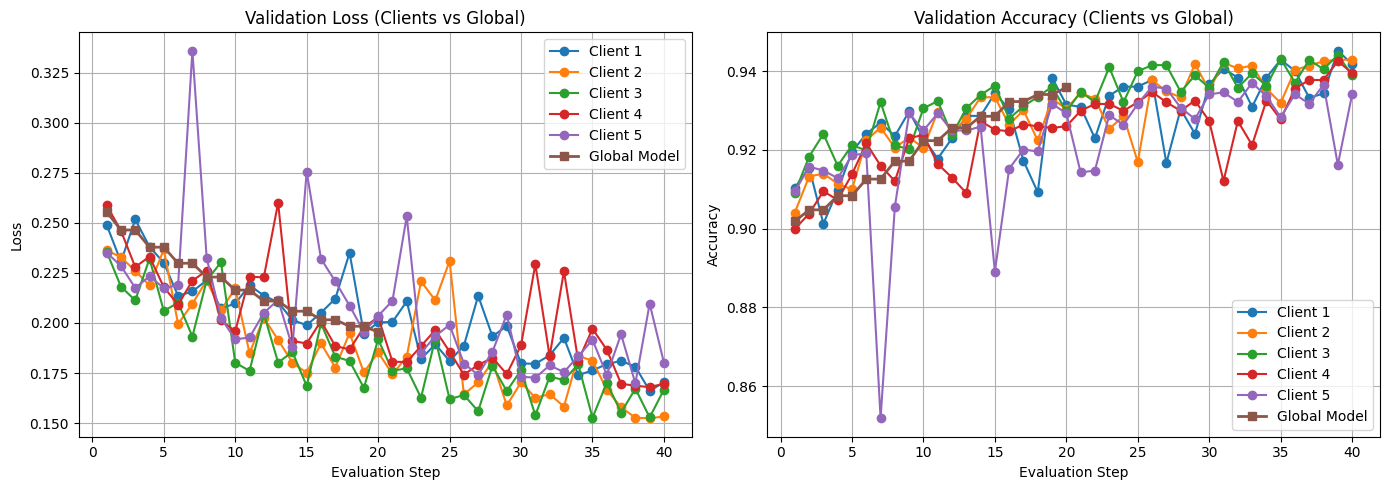

In [ ]:
import matplotlib.pyplot as plt

# ------------------------------
# Prepare figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ------------------------------
# Subplot 1: Validation Loss
for client_id, metrics in logger.client_metrics.items():
    losses = metrics["loss"]
    epochs = list(range(1, len(losses) + 1))
    axes[0].plot(epochs, losses, marker='o', label=f"Client {client_id + 1}")

# Global loss
global_losses = logger.global_metrics["loss"]
global_epochs = list(range(1, len(global_losses) + 1))
axes[0].plot(global_epochs, global_losses, marker='s', linewidth=2, label="Global Model")

axes[0].set_title("Validation Loss (Clients vs Global)")
axes[0].set_xlabel("Evaluation Step")
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()

# ------------------------------
# Subplot 2: Validation Accuracy
for client_id, metrics in logger.client_metrics.items():
    accuracies = metrics["accuracy"]
    epochs = list(range(1, len(accuracies) + 1))
    axes[1].plot(epochs, accuracies, marker='o', label=f"Client {client_id + 1}")

# Global accuracy
global_accs = logger.global_metrics["accuracy"]
global_epochs = list(range(1, len(global_accs) + 1))
axes[1].plot(global_epochs, global_accs, marker='s', linewidth=2, label="Global Model")

axes[1].set_title("Validation Accuracy (Clients vs Global)")
axes[1].set_xlabel("Evaluation Step")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# -------------------------------------------------
# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        "Validation Loss (Clients vs Global)",
        "Validation Accuracy (Clients vs Global)"
    )
)

# -------------------------------------------------
# Subplot 1: Validation Loss (Clients)
for client_id, metrics in logger.client_metrics.items():
    losses = metrics["loss"]
    steps = list([x / (client_epoch+1) for x in range(1, (client_epoch) * global_epoch + global_epoch+1)])

    fig.add_trace(
        go.Scatter(
            x=steps,
            y=losses,
            mode="lines+markers",
            name=f"Client {client_id + 1}",
            legendgroup=f"client{client_id + 1}",
            opacity=0.4
        ),
        row=1, col=1
    )

# Global model loss
global_losses = logger.global_metrics["loss"][::2]
global_steps = list(range(1, len(global_losses) + 1))

fig.add_trace(
    go.Scatter(
        x=global_steps,
        y=global_losses,
        mode="lines+markers",
        name="Global Model",
        legendgroup="global",
        marker=dict(symbol="square", size=8),
        line=dict(width=3)
    ),
    row=1, col=1
)

# -------------------------------------------------
# Subplot 2: Validation Accuracy (Clients)
for client_id, metrics in logger.client_metrics.items():
    accuracies = metrics["accuracy"]
    steps = list([x / (client_epoch+1) for x in range(1, (client_epoch) * global_epoch + global_epoch+1)])

    fig.add_trace(
        go.Scatter(
            x=steps,
            y=accuracies,
            mode="lines+markers",
            name=f"Client {client_id + 1}",
            legendgroup=f"client{client_id + 1}",
            showlegend=False,  # avoid duplicate legend
            opacity=0.4
        ),
        row=1, col=2
    )

# Global model accuracy
global_accs = logger.global_metrics["accuracy"][::2]
global_steps = list(range(1, len(global_accs) + 1))

fig.add_trace(
    go.Scatter(
        x=global_steps,
        y=global_accs,
        mode="lines+markers",
        name="Global Model",
        legendgroup="global",
        showlegend=False,
        marker=dict(symbol="square", size=8),
        line=dict(width=3)
    ),
    row=1, col=2
)

# -------------------------------------------------
# Axis labels
fig.update_xaxes(title_text="Evaluation Step", row=1, col=1)
fig.update_xaxes(title_text="Evaluation Step", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Accuracy", row=1, col=2)

# -------------------------------------------------
# Layout
fig.update_layout(
    height=520,
    width=1200,
    template="plotly_white",
    hovermode="x unified"
)
for g in range(1, global_epoch + 1):
    x = (g * client_epoch) / client_epoch

    fig.add_vline(
        x=x,
        line=dict(color="orange", dash="dash"),
        annotation_text="Quick FT" if g == 1 else "",
        annotation_position="top"
    )

fig.show()
